# Feature extraction for DLSite Works Images

There are several ways to convert images to vectors:
- ORB_SLAM3 (imsearch)
- ResNet
- Image hashing (aHash, pHash, dHash, wHash) and image deduplication techniques

In [1]:
# Basic dependencies
from pathlib import Path
import sys
import dataset_files
import cv2 as cv
import orb_slam3
import numpy as np
import time
import threading
import concurrent.futures
from pprint import pprint
from matplotlib import pyplot as plt

image_paths = []
fileext_dict = dataset_files.fileext_stat # Dictionary containing all DLSite work's file path, separated by file extensions
for extension in fileext_dict:
    if fileext_dict[extension]['MediaType'] == "Image":
        image_paths += fileext_dict[extension]['List']
        
pprint(image_paths)
print(f"Found {len(image_paths)} images in all three subsets")

[PosixPath('/mnt/Scratchpad/ASMROne/RJ01008923/04_イラスト/ジャケット.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01008923/04_イラスト/パッケージ.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01008923/04_イラスト/パッケージイラスト.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01011708/image/coverA_16x9.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01011708/image/coverA_4x3.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01011708/image/coverA_phone.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01011709/image/coverB_16x9.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01011709/image/coverB_4x3.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01011709/image/coverB_phone.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01016536/作品插圖（含標題）.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01049458/イラスト・台本/『秘書後輩』_パッケージイラスト.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01050049/【特典】ジャケットイラスト/純情少女、発情中。.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01050049/【特典】ジャケットイラスト/純情少女、発情中。（ロゴあり）.png'),
 PosixPath('/mnt/Scratchpad/ASMROne/RJ01050049/【限定特典】イラ

## Feature extraction: ORB_SLAM3

Test extraction:

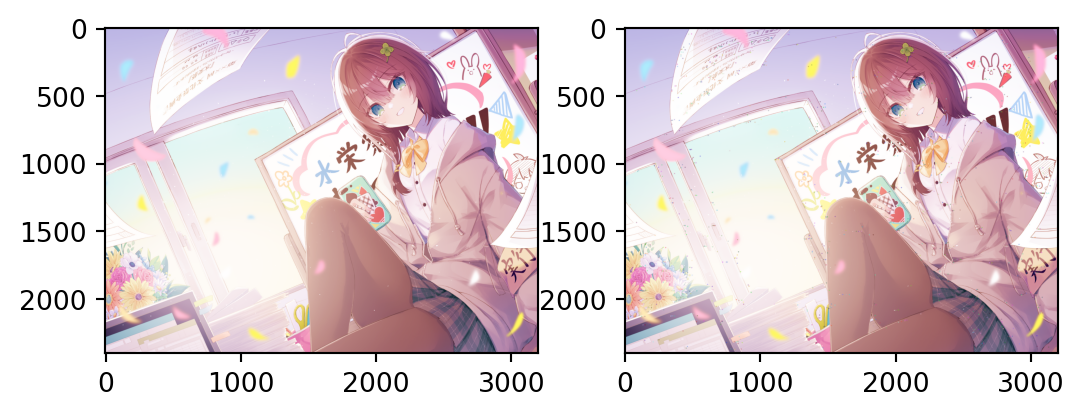

In [2]:
def cv_imreadW(file_path : str) -> cv.Mat:
    """Workaround for imread for reading image paths with Unicode characters.
    This function will load the image via numpy into memory, and then it will
    pass the array back to OpenCV using cv2.imdecode() with cv.IMREAD_UNCHANGED.
    It's like fucking 2025 and OpenCV still has no Unicode support? For shame.

    Args:
        file_path (str): Image Path

    Returns:
        cv.Mat: OpenCV Matrix (image)
    """
    img = cv.imdecode(np.fromfile(file_path, dtype=np.uint8), cv.IMREAD_UNCHANGED)
    return img

# Preparation
orb_extractor = orb_slam3.ORBExtractor(nfeatures=1000)

# Read test image path
test_image = cv_imreadW(image_paths[10])

# Extract features
keypoints, descriptors = orb_extractor.detectAndCompute(test_image)

# Draw keypoints and show plotted picture
fig, (ax1, ax2) = plt.subplots(1, 2)
test_image_rgb = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)
test_image_rgb_kp = cv.drawKeypoints(test_image_rgb, keypoints, None)
fig.set_dpi(192) # Make figure super large to see keypoints
ax1.imshow(test_image_rgb)
ax2.imshow(test_image_rgb_kp)

Extract features from all images and store in memory

In [ ]:
image_paths = image_paths[0:200] # to cut down test time

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

N_THREADS = 16
def threaded_orb_extractor(chunk : list[Path], orb: orb_slam3.ORBExtractor, write_dict : dict, w_lock : threading.Lock):
    """Given a list of Paths, using the given Orb extractor, adds feature vecrots to a dictionary with format "filepath": np.ndarray(32)
    Must provide a lock for multi-threading

    Args:
        chunk (list[Path]): List of Paths to images
        orb (orb_slam3.ORBExtractor): ORB extractor
        write_dict (dict): Target Dictionary to write
        w_lock (threading.Lock): Threading lock, must be the shared lock with other threads
    """
    # Iterate through all paths in given chunk
    for im_path in chunk:
        img_path = str(im_path.absolute())
        # Read image
        img = cv_imreadW(img_path)
        # Extract Descriptors with ORB, discarding keypoints list
        _, ds = orb.detectAndCompute(img)
        with w_lock:
            write_dict[img_path] = ds
    print(id(orb), "finished")

def check_futures_completed(ft : list) -> bool:
    """Pass in a list of futures and see if all of them have already finished. Returns true if all futures are done

    Args:
        ft (list): List of futures

    Returns:
        bool: If all tasks is done. Yes: true, No: false
    """
    are_we_completed = True
    for f in ft:
        if (f.running()):
            are_we_completed = False
            break # Me echarán de la escuela seguramente por usar un break aquí
    return are_we_completed

# Prepare result buffer and locks
image_vectors_orb = {} # Hashmap of "Image Path": Path --> Descriptors : cv.Mat (Matrix)
write_lock = threading.Lock()

print("Starting", 8, "threads for extraction")
t_start = time.perf_counter()
image_paths_len = len(image_paths)
with concurrent.futures.ThreadPoolExecutor(max_workers=N_THREADS) as executor:
    # Preparing parameters for each thread
    chunk_size = image_paths_len // N_THREADS + 1
    file_path_chunks = list(chunks(image_paths, chunk_size))
    orb_exts = [orb_slam3.ORBExtractor(nfeatures=1000) for _ in range(N_THREADS)]
    wr_dicts = [image_vectors_orb for _ in range(N_THREADS)] # In theory I am passing pointer of image_vectors_orb into it
    wr_locks = [write_lock for _ in range(N_THREADS)]
    futures = []
    for c, o, w, l in zip(file_path_chunks, orb_exts, wr_dicts, wr_locks):
        futures.append(executor.submit(threaded_orb_extractor, c, o, w, l))
        
    while (not check_futures_completed(futures)):
        print(f"Extracted feature vectors of {len(image_vectors_orb)}/{image_paths_len} images")
        time.sleep(1)
    
features_stored = sum( [len(image_vectors_orb[file_path]) for file_path in image_vectors_orb] )
t_end = time.perf_counter()
delta_t = round(t_end - t_start, 2)

print()
print(f"Successfully Indexed {len(image_vectors_orb)} files, stored {features_stored} vectors.")
print(f"Took {delta_t} seconds to extract all features")
print("Size in memory: ", sys.getsizeof(image_vectors_orb))

Starting 8 threads for extraction
Extracted feature vectors of 0/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 0/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 16/200 images
Extracted feature vectors of 16/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 33/200 images
Extracted feature vectors of 33/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 49/200 images
Extracted feature vectors of 49/200 images
Extracted feature vectors of 65/200 images
Extracted feature vectors of 65/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 77/200 images
128677095781296 finished


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
[ WARN:16@18.788] global grfmt_png.cpp:695 read_chunk chunk data is too large


Extracted feature vectors of 93/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 110/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 126/200 images
Extracted feature vectors of 126/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 142/200 images
Extracted feature vectors of 142/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 157/200 images


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 172/200 images
Extracted feature vectors of 172/200 images
128677095780464 finished
128677095781040 finished
128677095780784 finished


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Extracted feature vectors of 187/200 images
128677095780912 finished
128677095780848 finished
128677095780720 finished
128677095780528 finished
128677095780656 finished
128677095780400 finished
128677095781232 finished
128677095779952 finished
128677095780976 finished
128677095781104 finished
128677095781168 finished
128677095780592 finished

Successfully Indexed 200 files, stored 201166 vectors.
Took 36.12 seconds to extract all features
Size in memory:  6576


Although it is certainly possible to do feature extraction in Python, it feels very slow doing the extraction.

And this is only for 330 works. The feature extraction process must be opmized.

In Windows it takes 45 seconds to process 200 images. In Linux it takes 35 seconds to process 200 images.